In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticks 
import pandas as pd
import dateutil
import dateutil.parser as dp
import argparse
import scipy.stats 
import warnings
import glob
import os
import re
import SETTINGS

warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [2]:
start_date = '20181025'
end_date = '20201218'

start_date_dt = dp.parse(start_date) 
end_date_dt = dp.parse(end_date) 

min_date = dp.parse(SETTINGS.MIN_START_DATE)
max_date = dp.parse(SETTINGS.MAX_END_DATE)

if start_date_dt < min_date or end_date_dt > max_date:
    raise ValueError(f'Date must be in range {SETTINGS.MIN_START_DATE} - {SETTINGS.MAX_END_DATE}')

phi_dir = os.path.join(SETTINGS.PHI_DIR)
img_dir = os.path.join(SETTINGS.Z_CALIB_DIR,'images/')
if not os.path.exists(img_dir):
    os.makedirs(img_dir)
filelist1 = glob.glob(phi_dir+"phiest*")
filelist2 = glob.glob(phi_dir+"phiobs*")
filelist1.sort()
filelist2.sort()
dates=[]
ind=[]

if len(filelist1) != len(filelist2):
    raise ValueError("Number of phiest and phiobs files does not match!")

#Loop through files to find the indices of those between the inputted start and end dates
for f in range(0,len(filelist1)):
    match = re.search(r'\d{8}',filelist1[f])
    #print(match)
    #print(filelist1[f])
    file=match.group()
    #print(file)
    file_dt=dp.parse(file)
    if file_dt >= start_date_dt and file_dt <= end_date_dt:
        ind.append(f)
        dates.append(file)

ndays=len(ind)
print(ndays)

194


In [3]:
#If the number of elevation angles in the volumes changes over time, then the total number of rays also varies
#This loop finds the maximum number of rays
for f in range(0,ndays):
    file=np.load(filelist1[ind[f]])
    if f==0:
        [_,a]=file.shape
        nrays=a
    else:
        [_,a2]=file.shape
        if a2>a:
            nrays=a2

#Number of volumes can vary each day    
nvols=250
phiest=np.zeros((ndays,nvols,nrays))*np.nan
phiobs=np.zeros((ndays,nvols,nrays))*np.nan
good_rays=np.zeros((ndays,nvols))*np.nan
x=np.zeros((nvols,nrays))*np.nan

In [4]:
#Load each phiest and phiobs data for each day and store into 3D array. 
#Calculate number of good rays for each day/volume
d=0
for f in range(0,ndays):
    phiest1 = np.load(filelist1[ind[f]])
    [a,b] = phiest1.shape
    phiest[d,0:a,0:b] = phiest1    
    phiobs1 = np.load(filelist2[ind[f]])
    [a,b] = phiobs1.shape
    phiobs[d,0:a,0:b] = phiobs1
    d=d+1

#Calculate number of good rays in each volume. good_rays(ndays,nvols)
for j in range(ndays):    
    for i in range(nvols):
        good_rays[j,i] = np.nansum(np.isfinite(phiest[j,i,:]))

#bias_each_ray (ndays,nvols,nrays)
#Calculate a bias/offset for each individual ray
bias_each_ray = (phiest - phiobs) / phiobs

#Only use volumes with more than 10 good rays for calculation of overall bias.
ind = good_rays>10

#SINGLE VALUES FOR WHOLE TIME PERIOD
mean_bias = np.nanmean(bias_each_ray[ind,:])
mean_bias_db = 10.0*np.log10(1000+mean_bias*1000)-30
mean_bias_db_2 = 10*np.log10(10*(mean_bias+1)) - 10*np.log10(10)

median_bias = np.nanmedian(bias_each_ray[ind,:])
median_bias_db = 10.0*np.log10(1000.0+median_bias*1000.0)-30.0

std = np.nanstd(bias_each_ray[ind,:])
std_db = 10.0*np.log10(1000.0+std*1000.0)-30.0

print('Mean bias = ', mean_bias_db, 'Median bias = ', median_bias_db, 'Standard Deviation = ', std_db)
print('MB 2 =', mean_bias_db_2)

Mean bias =  -0.9870265489858667 Median bias =  -0.9467310834558802 Standard Deviation =  0.8734551604977234
MB 2 = -0.987026548985865


In [75]:
#DAILY VALUES OF BIAS
mean_bias_each_day=np.zeros(ndays)*np.nan
median_bias_each_day=np.zeros(ndays)*np.nan
std_each_day=np.zeros(ndays)*np.nan
std_error_each_day = np.zeros(ndays)*np.nan
num_rays_day=np.zeros(ndays)

for day in range(ndays):
    #good_rays has shape (days,vols)
    #find index for volumes with more than 10 good rays
    ind = good_rays[day,:]>10
    #find all rays on each day within these volumes
    bias_one_day = bias_each_ray[day,ind,:].flatten()
    std_error_each_day[day] = scipy.stats.sem(bias_one_day,nan_policy='omit')
    mean_bias_each_day[day] = np.nanmean(bias_one_day)
    median_bias_each_day[day] = np.nanmedian(bias_one_day)
    std_each_day[day] = np.nanstd(bias_one_day)
    
    #ind2 = np.isfinite(bias_one_day)        
    #if np.sum(ind2)>0:
        #std_error_each_day[day] = scipy.stats.sem(bias_one_day[ind2])
        #mean_bias_each_day[day] = np.nanmean(bias_one_day)
        #median_bias_each_day[day] = np.nanmedian(bias_one_day)
        #std_each_day[day] = np.nanstd(bias_one_day)

    #Number of rays for each day
    num_rays_day[day] = np.sum(np.isfinite(bias_one_day))

        
#Convert to dB 
mean_bias_each_day_db = 10.0*np.log10(1000.0+mean_bias_each_day*1000.0)-30.0
median_bias_each_day_db = 10.0*np.log10(1000.0+median_bias_each_day*1000.0)-30.0
std_each_day_db = 10.0*np.log10(1000.0+std_each_day*1000.0)-30.0
std_error_each_day_db = 10.0*np.log10(1000.0+std_error_each_day*1000.0)-30.0

In [78]:
#Put data into dataframe
time = pd.to_datetime(dates, format = '%Y%m%d')
data = pd.DataFrame({'Mean Bias' : mean_bias_each_day_db, 'Median Bias' : median_bias_each_day_db, 
                 'Standard Error' : std_error_each_day_db, 'Standard Deviation' : std_each_day_db}, 
                index=time) 

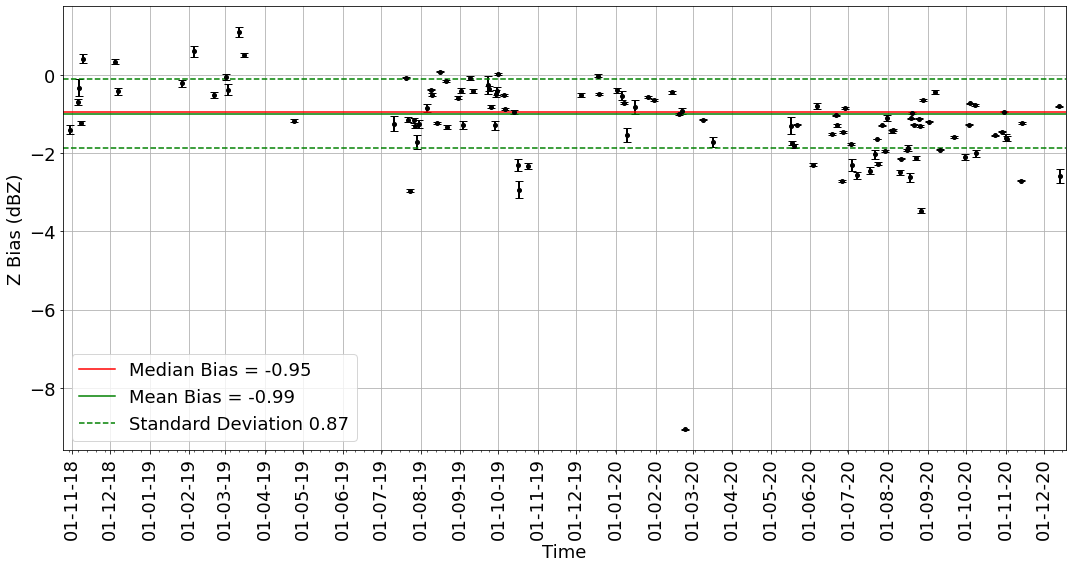

In [79]:
#Make plot       
fig, ax1 = plt.subplots(figsize=(15,8))    
plt.errorbar(data.index, mean_bias_each_day_db, std_error_each_day_db, 
                  color='black',fmt='o',markersize='4', elinewidth=2,capsize=4)
plt.plot([start_date_dt, end_date_dt],[median_bias_db,median_bias_db],'r-',
                  label="Median Bias = %s" % round(median_bias_db,2))
plt.plot([start_date_dt, end_date_dt],[mean_bias_db,mean_bias_db],'g', 
                  label="Mean Bias = %s" % round(mean_bias_db,2))
#plt.plot([start_date_dt, end_date_dt],[mean_bias_db+std_db*2,mean_bias_db+std_db*2],'g--',
#                  label="2XStandard Deviation %s" % round(std_db,2))
#plt.plot([start_date_dt, end_date_dt],[mean_bias_db-std_db*2,mean_bias_db-std_db*2],'g--')

plt.plot([start_date_dt, end_date_dt],[mean_bias_db+std_db,mean_bias_db+std_db],'g--',
                  label="Standard Deviation %s" % round(std_db,2))
plt.plot([start_date_dt, end_date_dt],[mean_bias_db-std_db,mean_bias_db-std_db],'g--')

#plt.plot(monthly_mean.index,monthly_mean['Mean Bias'],'ro')

#plt.plot(data.index, median_bias_each_day_db,'rx')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_minor_locator(mdates.WeekdayLocator(interval=1))
plt.xlim(start_date_dt,end_date_dt)

plt.xticks(rotation=90)
plt.xlabel('Time',{'fontsize':18})
plt.ylabel('Z Bias (dBZ)',{'fontsize':18})
plt.yticks(size=18)
plt.xticks(size=18)
plt.grid()
plt.legend(loc=0,fontsize=18)
   
    #If you want to overlay number of rays for each data point then uncomment these lines.
    #May need some tweaking to get the yaxis scale correct for the data you are plotting. 
#    ax2=ax1.twinx()
#    ax2.set_ylim(0,20000)
#    ax2.plot(data.index, num_rays_day,'bx-')
#    ax2.set_yticks([5000, 10000])
#    ax2.set_yticks([1000, 2000, 3000, 4000, 7500],minor=True)
#    plt.ylabel('Total number of Rays',{'fontsize':18})
#    plt.yticks(size=18)
#    plt.xlim(start_date_dt,end_date_dt)

#Save the plot
imgname = f'{img_dir}/Z_calibration_{start_date}_{end_date}_281021.png'
plt.tight_layout()
#plt.savefig(imgname,dpi=150)        
            